# <center> Identification of Internet users. Report

## <center> Идентификация интернет-пользователей

In [101]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import statistics as st
from collections import OrderedDict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

### Цели и задачи проекта, описание исходных и обработанных данных и признаков

Цель проекта – решить задачу идентификации пользователя по его поведению в сети (интернете) ["Catch Me If You Can ("Alice")"](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2).

Задача проекта – для каждой сессии идентифицировать пользователя по последовательности из нескольких посещенных им подряд веб-сайтов: по сеансу из веб-страниц (последовательности веб-страниц, которые последовательно посещает один и тот же человек) предсказывать, сессия принадлежит Алисе или другому пользователю.

Исходные данные.
Тренировочный набор данных состоит из призанков:
* site_i - идентификаторы сайтов в сессии;
* time_j - время посещения соответствующего сайта;
* target - отметка принадлежности сессии Элис.

Всего в тренировочном датасете 21 признак и 253561 сессий.

In [164]:
PATH_TO_DATA = 'capstone_user_identification'

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'))
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'))

train_df.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
0,1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
2,3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
3,4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
4,5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [103]:
print(f'Размер train_df: {train_df.shape},\nРазмер test_df: {test_df.shape}')

Размер train_df: (253561, 22),
Размер test_df: (82797, 21)


### Первичный анализ признаков

In [104]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253561 entries, 0 to 253560
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   session_id  253561 non-null  int64  
 1   site1       253561 non-null  int64  
 2   time1       253561 non-null  object 
 3   site2       250098 non-null  float64
 4   time2       250098 non-null  object 
 5   site3       246919 non-null  float64
 6   time3       246919 non-null  object 
 7   site4       244321 non-null  float64
 8   time4       244321 non-null  object 
 9   site5       241829 non-null  float64
 10  time5       241829 non-null  object 
 11  site6       239495 non-null  float64
 12  time6       239495 non-null  object 
 13  site7       237297 non-null  float64
 14  time7       237297 non-null  object 
 15  site8       235224 non-null  float64
 16  time8       235224 non-null  object 
 17  site9       233084 non-null  float64
 18  time9       233084 non-null  object 
 19  si

In [105]:
train_df.describe()

,session_id,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,target
count,253561.00000,253561.000000,250098.000000,246919.000000,244321.000000,241829.000000,239495.000000,237297.000000,235224.000000,233084.000000,231052.000000,253561.000000
mean,126781.00000,3243.550144,3272.400883,3303.987757,3325.109422,3343.406035,3352.312637,3395.546771,3430.157765,3438.400088,3460.388861,0.009059
std,73196.90014,7247.006212,7307.480404,7347.809918,7371.245606,7379.758550,7380.413775,7435.727671,7473.417900,7471.062652,7492.447548,0.094747
min,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,63391.00000,53.000000,53.000000,53.000000,52.000000,52.000000,52.000000,55.000000,55.000000,55.000000,55.000000,0.000000
50%,126781.00000,677.000000,677.000000,677.000000,677.000000,678.000000,679.000000,679.000000,704.000000,733.000000,733.000000,0.000000
75%,190171.00000,1980.000000,1980.000000,1986.500000,1995.000000,2054.000000,2077.000000,2197.000000,2287.000000,2366.000000,2403.000000,0.000000
max,253561.00000,41601.000000,41600.000000,41599.000000,41599.000000,41599.000000,41600.000000,41600.000000,41601.000000,41601.000000,41601.000000,1.000000


In [106]:
train_df.corr()

,session_id,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,target
session_id,1.000000,0.000148,-0.000555,0.002418,0.000069,-0.000249,-0.000506,0.001587,-0.001358,-0.001100,-0.000130,-0.000825
site1,0.000148,1.000000,0.514902,0.500357,0.478220,0.453853,0.435732,0.424916,0.412857,0.401177,0.389907,-0.001635
site2,-0.000555,0.514902,1.000000,0.527593,0.500292,0.479208,0.458275,0.440135,0.428706,0.412053,0.404113,-0.003593
site3,0.002418,0.500357,0.527593,1.000000,0.527657,0.498688,0.473901,0.456356,0.441512,0.424647,0.413347,-0.004641
site4,0.000069,0.478220,0.500292,0.527657,1.000000,0.524368,0.495692,0.474926,0.456774,0.435884,0.426124,-0.003328
site5,-0.000249,0.453853,0.479208,0.498688,0.524368,1.000000,0.515853,0.493816,0.473958,0.453116,0.435112,-0.005701
site6,-0.000506,0.435732,0.458275,0.473901,0.495692,0.515853,1.000000,0.514644,0.492870,0.462805,0.448115,-0.004205
site7,0.001587,0.424916,0.440135,0.456356,0.474926,0.493816,0.514644,1.000000,0.519706,0.493182,0.469826,-0.002898
site8,-0.001358,0.412857,0.428706,0.441512,0.456774,0.473958,0.492870,0.519706,1.000000,0.513953,0.488192,-0.006590
site9,-0.001100,0.401177,0.412053,0.424647,0.435884,0.453116,0.462805,0.493182,0.513953,1.000000,0.511839,-0.004619


In [107]:
train_df.target.value_counts()

0    251264
1      2297
Name: target, dtype: int64

In [108]:
train_df.isnull().sum()

session_id        0
site1             0
time1             0
site2          3463
time2          3463
site3          6642
time3          6642
site4          9240
time4          9240
site5         11732
time5         11732
site6         14066
time6         14066
site7         16264
time7         16264
site8         18337
time8         18337
site9         20477
time9         20477
site10        22509
time10        22509
target            0
dtype: int64

В обучающей выборке сессии состоят минимум из одного посещенного сайта, максимум – десяти сайтов. Из них 2297 сессий принадлежат Элис, остальные (251264 сессии) – другим пользователям. Классы сильно несбалансированны.

In [109]:
# признаки, содежащие идентификаторы сайтов, являются типом int64, время - object
times = [c for c in train_df.columns if train_df[c].dtype.name == 'object']
sites = [c for c in train_df.drop('target', axis=1).columns if train_df[c].dtype.name != 'object']

In [110]:
train_df[times].describe()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
count,253561,250098,246919,244321,241829,239495,237297,235224,233084,231052
unique,236707,233597,230761,228188,225795,223712,221851,219987,218006,216169
top,2014-03-27 08:11:18,2013-10-12 09:45:58,2013-10-12 09:57:42,2014-03-19 08:57:20,2014-03-26 11:23:56,2014-03-20 11:38:52,2014-03-20 11:38:52,2013-10-12 09:47:16,2014-02-19 09:28:36,2014-02-19 09:28:22
freq,6,5,6,6,6,6,6,6,6,6


Создадим новые признаки функцией new_feature:

In [165]:
def new_feature(dataframe, features):
    # Создадим частотный словарь сайтов site_dict вида {site_id: site_freq}              
    site_dict = dict(pd.Series(dataframe[sites].values.ravel('F')).value_counts())
    # "таблица" с новыми признакми для всех сессий     
    new_feture_list = []
    
    # Определяем топ 50 сайтов по посещаемости
    top50_id = {site_id for site_id in list(site_dict.keys())[:50]}
    
    # Проходим по каждой сессии (строке из dataframe) и определяем новые призанки, делаем из них таблицу
    for session in range(dataframe.shape[0]):
        
        # строка датафрейма с текущей сессией
        session_current = dataframe.iloc[session]
        # сайты из текущей сессии
        session_sites = session_current[sites]
        # время посещания сайтов из текущей сессии
        session_times = session_current[times]
        
        # количество сайтов, входящих в топ 50, которые посетил пользователь
        top50_num = len(set(session_sites) & top50_id)
        
        # самый часто встречающийся сайт в сессии
        # если таких сайтов несколько, то берем тот, который пользователь посетил раньше (по времени в сессии)
        try:
            mode_site = st.mode(session_sites)
        except:
            mode_site = None
            
        unique_sites = np.unique(list(filter(lambda num: num != 0, session_sites))).shape[0]
            
        # разница во времени между посещениями сайтов
        time_diff = []        
        for num in range(len(session_times)-1):
            try:
                time_diff += [int((datetime.strptime(session_times[num + 1], "%Y-%m-%d %H:%M:%S") - \
                                   datetime.strptime(session_times[num], "%Y-%m-%d %H:%M:%S")).total_seconds())]
            except:
                time_diff += [0]
                
        # среднее время пребывания пользователя на сайте
        mean_site_time = np.mean(time_diff)
        
        # длина сессии
        length_session = sum(time_diff)
        
        # день недели начала сессии
        time_1 = datetime.strptime(session_times[0], "%Y-%m-%d %H:%M:%S")
        day_of_week = time_1.weekday()
        
        # час начала сессии
        start_session =  time_1.hour
            
        # время суток начала сессии
        if start_session >= 6 and start_session <= 11:
            time_of_day = 'morning'
        elif start_session > 11 and start_session <= 17:
            time_of_day = 'day'
        elif start_session > 17 and start_session <= 21:
            time_of_day = 'evening'
        else:
            time_of_day = 'night'
        
        new_feture_list += [[top50_num] + [mode_site] + [unique_sites] + [mean_site_time] + [length_session] +\
                            [start_session] + [day_of_week] + [time_of_day] + time_diff]
        
    # преобразование в DataFrame
    new_feture_df = pd.DataFrame(new_feture_list, columns=features)
            
    return new_feture_df

In [166]:
%%time
features = ['top50 num', 'mode site', 'unique sites', 'mean site time',
            'session lenght', 'session start', 'week day', 'time of day'] + ['time_diff' + str(j) for j in range(1,10)]
new_feature_train_df = new_feature(train_df, features)
new_feature_test_df = new_feature(test_df, features)

Wall time: 6min 53s


Заменим пропущенные значения в сессиях (в которых меньше 10 посещенных сайтов) на 0.

In [167]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

**Соединим новые вризнаки с исходными данными**

In [168]:
train_and_new_feature_df = pd.concat([train_df, new_feature_train_df], axis=1)
test_and_new_feature_df = pd.concat([test_df, new_feature_test_df], axis=1)

In [169]:
new_feature_train_df['target'] = train_df['target']
new_feature_train_df.head()

,top50 num,mode site,unique sites,mean site time,session lenght,session start,week day,time of day,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,target
0,0,1.0,11,0.000000,0,10,3,morning,0,0,0,0,0,0,0,0,0,0
1,2,941.0,8,2.888889,26,11,5,morning,0,1,0,0,0,1,0,23,1,0
2,3,14768.0,5,0.777778,7,16,0,day,1,1,0,0,0,1,1,1,2,0
3,1,782.0,2,30.000000,270,10,4,morning,30,30,30,30,30,30,30,30,30,0
4,4,177.0,5,27.333333,246,10,4,morning,137,0,1,0,36,0,0,67,5,0


### Первичный визуальный анализ признаков

**Распределения количества сайтов в сессии, которые входят в топ 50 самых посещаемых сайтов (top50 num)**

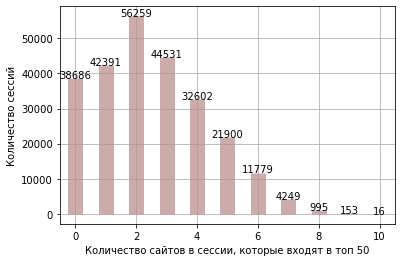

In [49]:
top50_num = dict(OrderedDict(sorted(new_feature_train_df['top50 num'].value_counts().items(), key=lambda t: t[0])))

plt.vlines(x=list(top50_num.keys()), ymin=0, \
           ymax=list(top50_num.values()), color='rosybrown', alpha=0.75, linewidth=15)

plt.xlabel('Количество сайтов в сессии, которые входят в топ 50')
plt.ylabel('Количество сессий')
plt.grid()

for i, num in enumerate(list(top50_num.values())):
    plt.text(i, num, num, horizontalalignment='center')

Чаще всего встречаются сессии, где есть два уникальных сайта (56259 сессий). Также есть не мало сессий, в которых сайты не которые входят в топ 50 (38686 сессий). Есть сессии, в которых все сайты входят в топ 50 (16 сессий).

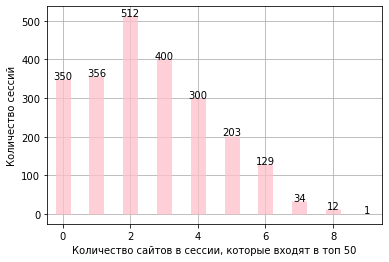

In [113]:
top50_num_Alice = dict(OrderedDict(sorted(new_feature_train_df[new_feature_train_df['target']==1]['top50 num'].value_counts().items(), key=lambda t: t[0])))

plt.vlines(x=list(top50_num_Alice.keys()), ymin=0, \
           ymax=list(top50_num_Alice.values()), color='pink', alpha=0.75, linewidth=15)

plt.xlabel('Количество сайтов в сессии, которые входят в топ 50')
plt.ylabel('Количество сессий')
plt.grid()
    
for i, num in enumerate(list(top50_num_Alice.values())):
    plt.text(i, num, num, horizontalalignment='center')

В случае Алисы распределение похоже на распределение со всеми пользователями: так же чаще всего встречаются сессии, где есть два уникальных сайта (512 сессий), и есть не мало сессий, в которых сайты не которые входят в топ 50 (350 сессий). Всего одна сессия, в которой все сайты входят в топ 50.

**Распределение сайтов, котрые были самыми посещаемыми сайтами в сессии (mode site)**

Для всех пользователей

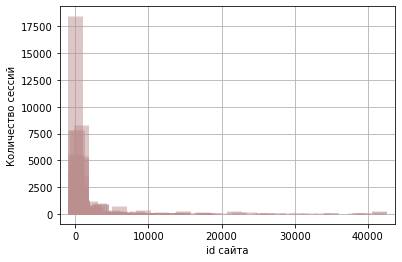

In [115]:
plt.vlines(x=new_feature_train_df['mode site'].value_counts().index, ymin=0, \
           ymax=new_feature_train_df['mode site'].value_counts().values, color='rosybrown', alpha=0.5, linewidth=15)

plt.xlabel('id сайта')
plt.ylabel('Количество сессий')
plt.grid()

Для Алисы

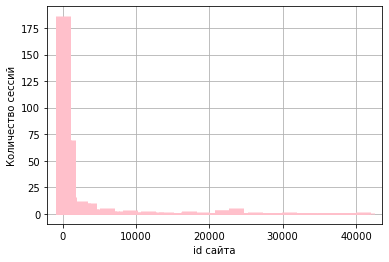

In [122]:
plt.vlines(x=new_feature_train_df[new_feature_train_df['target']==1]['mode site'].value_counts().index, ymin=0, \
           ymax=new_feature_train_df[new_feature_train_df['target']==1]['mode site'].value_counts().values, color='pink', alpha=1, linewidth=15)

plt.xlabel('id сайта')
plt.ylabel('Количество сессий')
plt.grid()

Большинство сайтов расположено в левой части диаграммы (id примерно с 1 до 200), посмотрим на эту часть поближе

Все пользователи

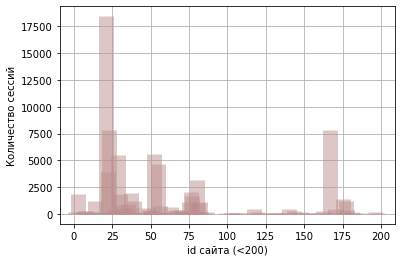

In [59]:
mode_site = dict(new_feature_train_df[new_feature_train_df['mode site']<200]['mode site'].value_counts())

plt.vlines(x=list(mode_site.keys()), ymin=0, \
           ymax=list(mode_site.values()), color='rosybrown', alpha=0.5, linewidth=15)

plt.xlabel('id сайта (<200)')
plt.ylabel('Количество сессий')
plt.grid()

In [43]:
new_feature_train_df['mode site'].value_counts().head(10)

21.0     18439
782.0     8266
23.0      7854
167.0     7807
52.0      5562
29.0      5509
780.0     5378
812.0     5171
55.0      4615
22.0      3870
Name: mode site, dtype: int64

In [47]:
sum(new_feature_train_df['mode site'].value_counts()==1)

6651

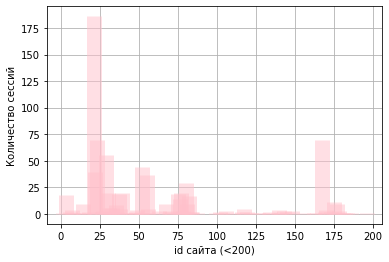

In [134]:
Alice_target = new_feature_train_df[new_feature_train_df['target']==1]
mode_site = dict(Alice_target[Alice_target['mode site']<200]['mode site'].value_counts())

plt.vlines(x=list(mode_site.keys()), ymin=0, \
           ymax=list(mode_site.values()), color='pink', alpha=0.5, linewidth=15)

plt.xlabel('id сайта (<200)')
plt.ylabel('Количество сессий')
plt.grid()

In [135]:
new_feature_train_df[new_feature_train_df['target']==1]['mode site'].value_counts().head(10)

21.0     186
167.0     70
23.0      70
782.0     70
29.0      55
780.0     52
812.0     48
52.0      44
22.0      39
55.0      37
Name: mode site, dtype: int64

In [136]:
sum(new_feature_train_df[new_feature_train_df['target']==1]['mode site'].value_counts()==1)

520

Самым посещаемым среди наиболее встречающихся сайтов сессии является сайт с id 21 (18439 сессий), на втором месте - id 782 (8266 сессий). 6651 (кол-во) сайт был самым часто встречающимся сайтом в одной сессиях один раз.

У Алисы самым посещаемым среди наиболее встречающихся сайтов сессии является сайт с id 21 (186 сессий), на втором месте - id 167 (70 сессий). 520 сайтов были самыми часто встречающимся сайтами в сессиях один раз.

**Распределение количества уникальных сайтов в сессии (unique sites)**

Для всех пользователей

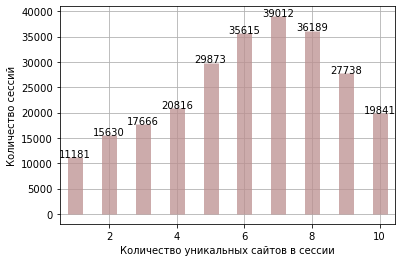

In [57]:
unique_sites = dict(OrderedDict(sorted(new_feature_train_df['unique sites'].value_counts().items(), key=lambda t: t[0])))

plt.vlines(x=list(unique_sites.keys()), ymin=0, \
           ymax=list(unique_sites.values()), color='rosybrown', alpha=0.75, linewidth=15)

plt.xlabel('Количество уникальных сайтов в сессии')
plt.ylabel('Количество сессий')
plt.grid()

for i, num in enumerate(list(unique_sites.values())):
    plt.text(i+1, num, num, horizontalalignment='center')

В большинстве сессий (39012) количество уникальных сайтов 7. Реже всего в сессиях (1181) встречалось по 1 уникальному сайту. Все 10 уникальных сайтов было в 19841 сессии.

Для Алисы

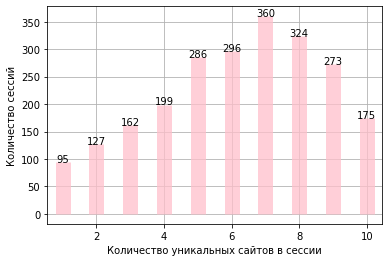

In [146]:
unique_sites_alice = dict(OrderedDict(sorted(Alice_target['unique sites'].value_counts().items(), key=lambda t: t[0])))

plt.vlines(x=list(unique_sites_alice.keys()), ymin=0, \
           ymax=list(unique_sites_alice.values()), color='pink', alpha=0.75, linewidth=15)

plt.xlabel('Количество уникальных сайтов в сессии')
plt.ylabel('Количество сессий')
plt.grid()

for i, num in enumerate(list(unique_sites_alice.values())):
    plt.text(i+1, num, num, horizontalalignment='center')

Распределение количества уникальных сайтов в сессии такое же, как и у всех пользователей. В большинстве сессий (360) количество уникальных сайтов 7. Реже всего в сессиях (95) встречалось по 1 уникальному сайту. Все 10 уникальных сайтов было в 175 сессии.

**Распределение среднего времени пребывания пользователя на сайтеmean (mean site time)**

Для всех пользователей

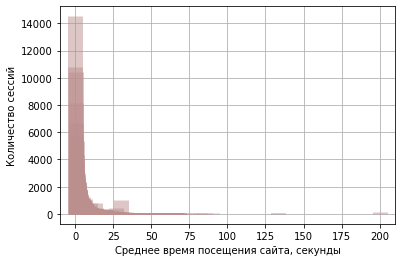

In [74]:
mean_site_time = dict(new_feature_train_df[new_feature_train_df['mean site time']!=0]['mean site time'].value_counts())

plt.vlines(x=list(mean_site_time.keys()), ymin=0, \
           ymax=list(mean_site_time.values()), color='rosybrown', alpha=0.5, linewidth=15)

plt.xlabel('Среднее время посещения сайта, секунды')
plt.ylabel('Количество сессий')
plt.grid()

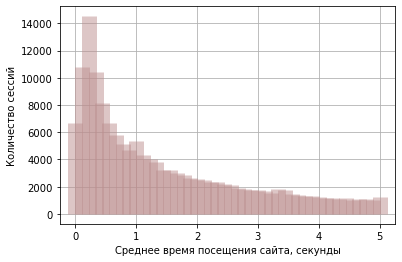

In [79]:
mean_site_time = dict(new_feature_train_df[new_feature_train_df['mean site time']<=5]['mean site time'].value_counts())

plt.vlines(x=list(mean_site_time.keys()), ymin=0, \
           ymax=list(mean_site_time.values()), color='rosybrown', alpha=0.5, linewidth=15)

plt.xlabel('Среднее время посещения сайта, секунды')
plt.ylabel('Количество сессий')
plt.grid()

In [80]:
new_feature_train_df[new_feature_train_df['mean site time']!=0]['mean site time'].value_counts().head()

0.222222    14524
0.111111    10826
0.333333    10459
0.444444     8126
0.555556     6645
Name: mean site time, dtype: int64

In [81]:
new_feature_train_df[new_feature_train_df['mean site time']!=0]['mean site time'].value_counts().tail()

141.888889    2
154.222222    2
160.888889    2
150.111111    2
128.666667    2
Name: mean site time, dtype: int64

In [87]:
new_feature_train_df[new_feature_train_df['mean site time']!=0]['mean site time'].min()

0.1111111111111111

In [92]:
new_feature_train_df[new_feature_train_df['mean site time']!=0]['mean site time'].max()

200.0

Для Алисы

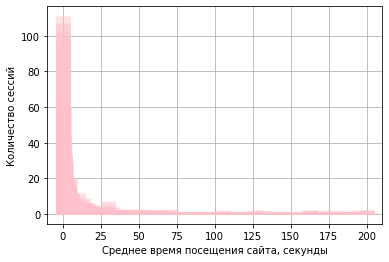

In [147]:
mean_site_time = dict(Alice_target['mean site time'].value_counts())

plt.vlines(x=list(mean_site_time.keys()), ymin=0, \
           ymax=list(mean_site_time.values()), color='pink', alpha=0.5, linewidth=15)

plt.xlabel('Среднее время посещения сайта, секунды')
plt.ylabel('Количество сессий')
plt.grid()

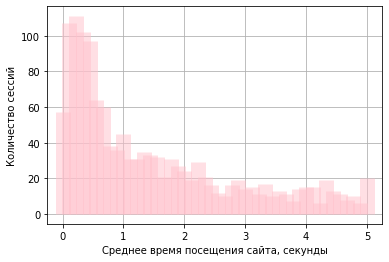

In [153]:
mean_site_time = dict(Alice_target[Alice_target['mean site time']<=5]['mean site time'].value_counts())

plt.vlines(x=list(mean_site_time.keys()), ymin=0, \
           ymax=list(mean_site_time.values()), color='pink', alpha=0.5, linewidth=15)

plt.xlabel('Среднее время посещения сайта, секунды')
plt.ylabel('Количество сессий')
plt.grid()

In [158]:
Alice_target[Alice_target['mean site time']!=0]['mean site time'].min()

0.1111111111111111

In [159]:
Alice_target[Alice_target['mean site time']!=0]['mean site time'].max()

200.0

В большинстве сессий посещение одного сайта в среднем длилось меньше минуты, самое минимальное - 0.11 секунды, максимальное - 200 секунд (3.33 минуты).

**Распределение длины сессии (session lenght)**

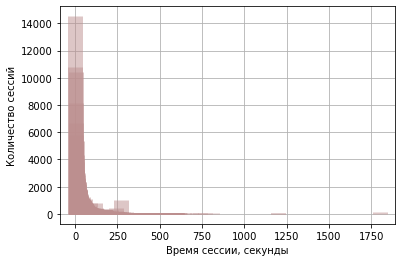

In [93]:
# исключим время равное 0, т.к. это сессии из одного сайта, по которым нельзя определить продолжительность посещения
session_lenght = dict(new_feature_train_df[new_feature_train_df['session lenght']!=0]['session lenght'].value_counts())

plt.vlines(x=list(session_lenght.keys()), ymin=0, \
           ymax=list(session_lenght.values()), color='rosybrown', alpha=0.5, linewidth=15)

plt.xlabel('Время сессии, секунды')
plt.ylabel('Количество сессий')
plt.grid()

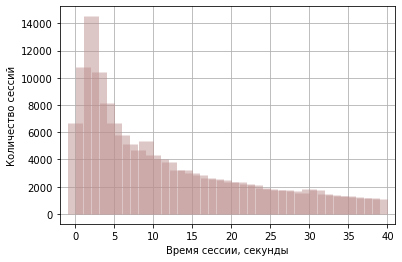

In [100]:
session_lenght = dict(new_feature_train_df[new_feature_train_df['session lenght']<40]['session lenght'].value_counts())

plt.vlines(x=list(session_lenght.keys()), ymin=0, \
           ymax=list(session_lenght.values()), color='rosybrown', alpha=0.5, linewidth=15)

plt.xlabel('Время сессии, секунды')
plt.ylabel('Количество сессий')
plt.grid()

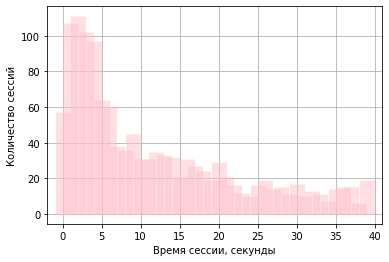

In [161]:
session_lenght = dict(Alice_target[Alice_target['session lenght']<40]['session lenght'].value_counts())

plt.vlines(x=list(session_lenght.keys()), ymin=0, \
           ymax=list(session_lenght.values()), color='pink', alpha=0.5, linewidth=15)

plt.xlabel('Время сессии, секунды')
plt.ylabel('Количество сессий')
plt.grid()

In [101]:
new_feature_train_df[new_feature_train_df['session lenght']!=0]['session lenght'].value_counts().head()

2    14524
1    10826
3    10459
4     8126
5     6645
Name: session lenght, dtype: int64

In [102]:
new_feature_train_df[new_feature_train_df['session lenght']!=0]['session lenght'].value_counts().tail()

1277    2
1388    2
1351    2
1158    2
1448    2
Name: session lenght, dtype: int64

In [103]:
new_feature_train_df[new_feature_train_df['session lenght']!=0]['session lenght'].min()

1

In [105]:
new_feature_train_df[new_feature_train_df['session lenght']!=0]['session lenght'].max()

1800

Так же как и в случае среднего времени пребывания пользователя на сайтеmean (mean site time), длина сессий в большинстве серий меньше минуты, минимальная длина - 1 секунда, максимальная - 1800 секунд (30 минут).

**Распределение часа начала сессии (session start)**

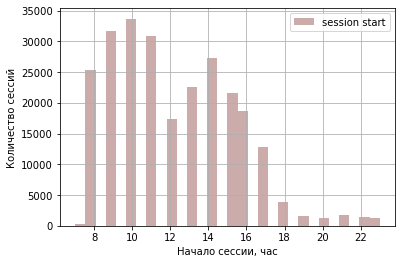

In [143]:
new_feature_train_df['session start'].plot.hist(bins=30, color='rosybrown', alpha=0.75, legend='session start')

plt.xlabel('Начало сессии, час')
plt.ylabel('Количество сессий')
plt.grid()

In [155]:
new_feature_train_df['session start'].value_counts()

10    33676
9     31741
11    30798
14    27306
8     25369
13    22552
15    21640
16    18739
12    17420
17    12830
18     3898
21     1705
19     1540
22     1467
23     1339
20     1200
7       341
Name: session start, dtype: int64

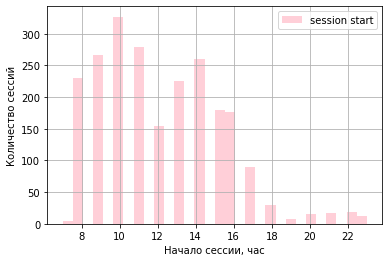

In [144]:
new_feature_train_df[new_feature_train_df['target']==1]['session start'].plot.hist(bins=30, color='pink', alpha=0.75, legend='session start')
plt.xlabel('Начало сессии, час')
plt.ylabel('Количество сессий')
plt.grid()

Большинство сессий были начаты в промежуток времени 8-11 часов, также это видно на следующей диаграмме (по признаку time of day). У Алисы аналогичное распределение.

**Диаграмма времени суток начала сессии (time of day)**

Для всех пользователей

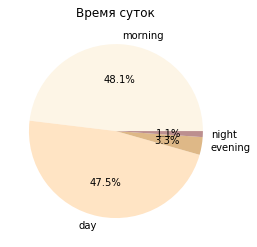

In [41]:
morning, day, evening, night = new_feature_train_df['time of day'].value_counts()

labels = ['morning','day','evening','night']
values = [morning, day, evening, night]
colors = ['oldlace', 'bisque', 'burlywood', 'rosybrown']

plt.pie(values, labels=labels, autopct='%.1f%%', colors=colors)
plt.title('Время суток');

In [61]:
new_feature_train_df['time of day'].value_counts()

morning    121925
day        120487
evening      8343
night        2806
Name: time of day, dtype: int64

По диаграмме видно, что наибольшую активность пользователи проявляют утром и днем. Количество сессий, которые были начаты утром (121 925 сессий), ненамного больше тех, что начаты днем (120 487 сессий). Ночью было начато всего 2806 сессий, немного меньше, чем вечером (8343 сессии)

Для Алисы

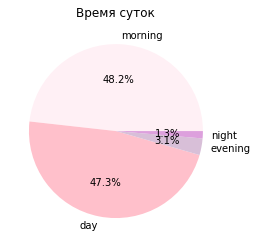

In [141]:
morning, day, evening, night = new_feature_train_df[new_feature_train_df['target']==1]['time of day'].value_counts()

labels = ['morning','day','evening','night']
values = [morning, day, evening, night]
colors = ['lavenderblush', 'pink', 'thistle', 'plum']

plt.pie(values, labels=labels, autopct='%.1f%%', colors=colors)
plt.title('Время суток');

Диаграмма для Алисы аналогична диаграмме для всех пользователей

**Гистограмма распределения дня недели начала сессии (week day)**

Все пользователи

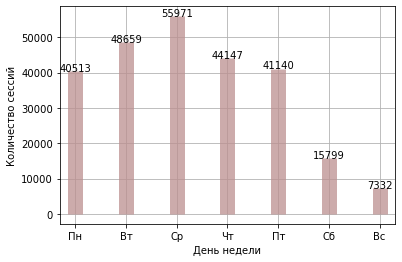

In [38]:
days_dict = dict(OrderedDict(sorted(new_feature_train_df['week day'].value_counts().items(), key=lambda t: t[0])))

plt.vlines(x=list(days_dict.keys()), ymin=0, \
           ymax=list(days_dict.values()), color='rosybrown', alpha=0.75, linewidth=15)

plt.xlabel('День недели')
plt.ylabel('Количество сессий')
plt.grid()
DayOfWeekOfCall = [0, 1, 2, 3, 4, 5, 6]
days_of_week =  ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

for i, num in enumerate(list(days_dict.values())):
    plt.text(i, num, num, horizontalalignment='center')
plt.xticks(DayOfWeekOfCall, days_of_week);

По гистограмме видно, что в будние дни (особенно в среду - 55971 сессия) пользователи чаще начинают сессии, чем в выходные.

Алиса

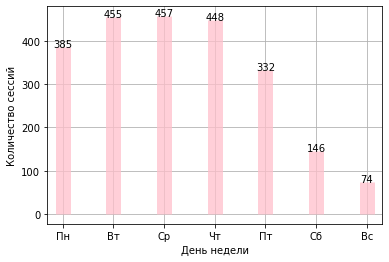

In [137]:
days_dict_alice = dict(OrderedDict(sorted(new_feature_train_df[new_feature_train_df['target']==1]['week day'].value_counts().items(), key=lambda t: t[0])))

plt.vlines(x=list(days_dict_alice.keys()), ymin=0, \
           ymax=list(days_dict_alice.values()), color='pink', alpha=0.75, linewidth=15)

plt.xlabel('День недели')
plt.ylabel('Количество сессий')
plt.grid()
DayOfWeekOfCall = [0, 1, 2, 3, 4, 5, 6]
days_of_week =  ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

for i, num in enumerate(list(days_dict_alice.values())):
    plt.text(i, num, num, horizontalalignment='center')
plt.xticks(DayOfWeekOfCall, days_of_week);

у Алисы так же большинство сессий начиналось в будние дни, особенно со вторника по четверг. 

Все распределения и диаграммы признаков всех пользователей и Алисы похожи, чего-то выделяющегося в поведении Алисы нет.

### Кросс-валидация, построение кривых валидации и обучения

In [82]:
def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.xlabel('С')
    plt.ylabel('ROC-AUC')
    plt.show()

In [86]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

### Кросс-валидация на LogisticRegression

**Обучим модель только на исходных признаках**

In [116]:
test_train_df = pd.concat([train_df, test_df], axis=0)
test_train_df.to_csv('train_test_df.txt', 
                                 sep=' ', index=None, header=None)

In [117]:
%%time
cv = CountVectorizer()
with open('train_test_df.txt') as inp_train_test_file:
    X = cv.fit_transform(inp_train_test_file)
X = X[:,1:]
X_train = X[:train_df.shape[0]]
X_test = X[train_df.shape[0]:]
y = train_df['target']

Wall time: 17.1 s


LogisticRegression(C=5) score = 0.9619962880543894


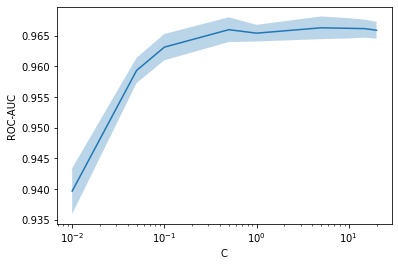

In [99]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20]}

lr_clf = GridSearchCV(LogisticRegression(), param_grid, scoring='roc_auc', cv=5)
lr_clf.fit(X_train, y)

print(lr_clf.best_estimator_, 'score =', lr_clf.cv_results_['mean_test_score'].mean())
plot_scores(lr_clf)

In [100]:
predict = lr_clf.best_estimator_.predict_proba(X_test)[:,1:]
write_to_submission_file(predict, 'answer_C-5_2')

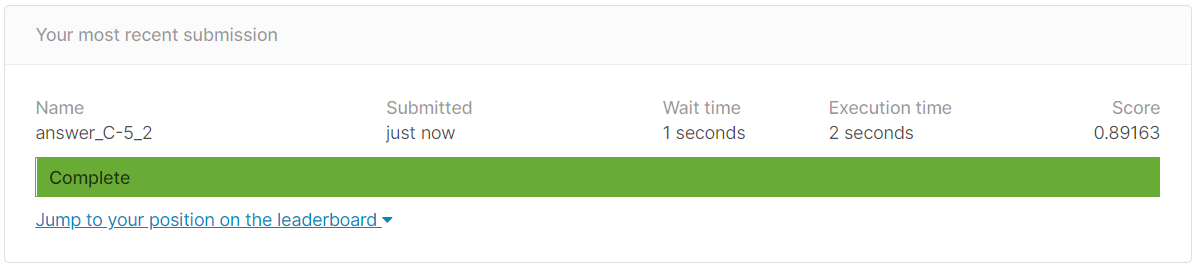

**Попробуем обучить модель на исходных и новых признаках**

In [170]:
train_and_new_feature_df.drop(['time_diff' + str(j) for j in range(1,10)], axis=1, inplace=True)

In [171]:
test_train_df = pd.concat([train_and_new_feature_df, test_and_new_feature_df], axis=0)
test_train_df.to_csv('train_test_text.txt', 
                                 sep=' ', index=None, header=None)

In [172]:
%%time
cv = CountVectorizer()
with open('train_test_text.txt') as inp_train_test_file:
    X = cv.fit_transform(inp_train_test_file)
X = X[:,1:]
X_train = X[:train_df.shape[0]]
X_test = X[train_df.shape[0]:]
y = train_df['target']

Wall time: 18.6 s


LogisticRegression(C=0.5) score = 0.9721318607029903


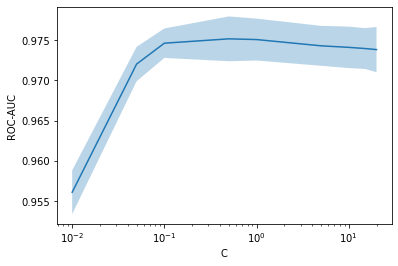

In [173]:
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 15, 20]}

lr_clf = GridSearchCV(LogisticRegression(), param_grid, scoring='roc_auc', cv=5)
lr_clf.fit(X_train, y)

print(lr_clf.best_estimator_, 'score =', lr_clf.cv_results_['mean_test_score'].mean())
plot_scores(lr_clf)

In [174]:
predict = lr_clf.best_estimator_.predict_proba(X_test)[:,1:]
write_to_submission_file(predict, 'answer_C-5')

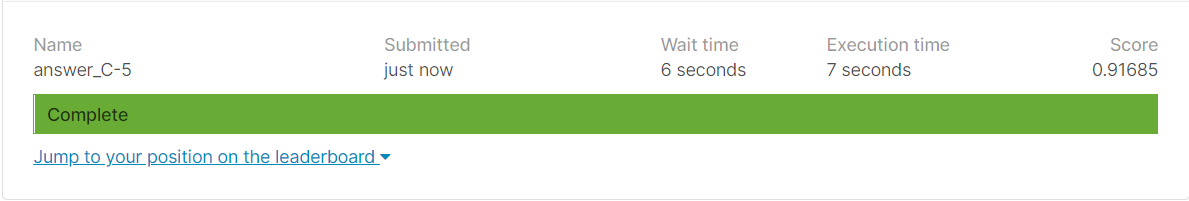

Качество стало выше

Лучшее качество получилось на мдели LogisticRegression с C=5, обученной на исходных данных и новых признаках. Качество получилось хорошее, оно равно 0.91685.

Построенная модель может применяться на практике, чтобы идентифицировать поведение определенного пользователя, также с ее помощью можно решать задачи, где необходимо идентифицировать несколько разных пользователей.

Чтобы улучшить качество, можно поработать над дисбалансом классов, например, добавить в данные больше сессий Алисы